### Import the necessary libraries

In [0]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

Using TensorFlow backend.


### Load the training data from train.csv file

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import pandas as pd
train_df = pd.read_csv('/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/train_labels.csv')

### Print the shape of the train dataset

In [0]:
train_df.shape

(173, 8)

In [0]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
import os 
os.chdir('/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/images 2/images')

In [0]:
train_df.shape[0]

173

In [0]:
import csv
paths = []
coords = np.zeros((train_df.shape[0], 4))
for i in range(len(train_df)):
  path = "/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/images 2/images/" + train_df.iloc[i,0]
  image_width = train_df.iloc[i,1]
  image_height = train_df.iloc[i,2]
  x0 = train_df.iloc[i,4]
  y0 = train_df.iloc[i,5]
  x1 = train_df.iloc[i,6]
  y1 = train_df.iloc[i,7]
  coords[i, 0] =  x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
  coords[i, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
  coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
  coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height
  paths.append(path)
       

batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    try:
        img = Image.open(f) # Read image
    except:
        print(i)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
                 

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

Instructions for updating:
Colocations handled automatically by placer.
17227776/17225924 [==============================] - 0s 0us/step


### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=0)

### Pick a test image from the given data

In [0]:
import cv2
filename = '/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/images 2/images/raccoon-17.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

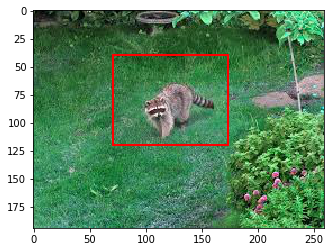

In [0]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## Problem 2 : Time Series Analysis using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temperature values to "Temperature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temperature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

### Import required libraries

In [0]:
temp_df = pd.read_csv('/content/drive/My Drive/deep learning/Residency 9 Labs and Projects/daily-minimum-temperatures-in-me.csv')

#### Mount google drive

### Load the  data file

In [0]:
temp_df.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Plot the data

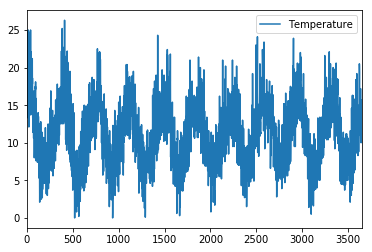

In [0]:
temp_df.plot()

### Check for null values and treat them

In [0]:
print(temp_df.isnull().any(axis=1).sum())

0


#### Drop null values (if any)

### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff25dd7358>]],
      dtype=object)

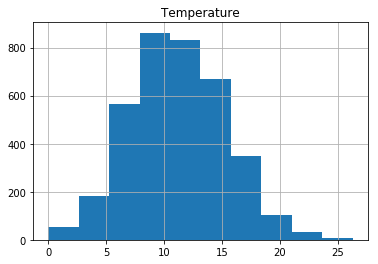

In [0]:
temp_df.hist(bins=10)

### Check the maximum and minimum values

In [0]:
# Scaled Data
print('Min', np.min(temp_df))
print('Max', np.max(temp_df))

Min Date           1981-01-01
Temperature             0
dtype: object
Max Date           1990-12-31
Temperature          26.3
dtype: object


### Normalize the data

In [0]:
columns_to_keep = ['Temperature']
lstm_df = temp_df[columns_to_keep]

In [0]:
from sklearn.preprocessing import MinMaxScaler
dataset = lstm_df.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Check the maximum and minimum values of scaled data

In [0]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


### Split data into Training and Testing set 
<u>Note</u> The train and test data has to be sequential. Keep the first 70% of data in training and the bottom 30% in test data 

In [0]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temperature at a particular time t to the temperature at time t+n, where n is any number you define.

For example: to map temperatures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Use function to get training and test set

In [0]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


### Define sequntial model, add LSTM layer and compile the model

In [0]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers

In [0]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Train the model for 100 epochs with batch size = 1

In [0]:
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 15s - loss: 0.0183
Epoch 2/100
 - 14s - loss: 0.0136
Epoch 3/100
 - 14s - loss: 0.0128
Epoch 4/100
 - 14s - loss: 0.0130
Epoch 5/100
 - 14s - loss: 0.0126
Epoch 6/100
 - 14s - loss: 0.0124
Epoch 7/100
 - 14s - loss: 0.0120
Epoch 8/100
 - 14s - loss: 0.0120
Epoch 9/100
 - 14s - loss: 0.0119
Epoch 10/100
 - 14s - loss: 0.0116
Epoch 11/100
 - 14s - loss: 0.0114
Epoch 12/100
 - 14s - loss: 0.0112
Epoch 13/100
 - 14s - loss: 0.0107
Epoch 14/100
 - 14s - loss: 0.0106
Epoch 15/100
 - 14s - loss: 0.0107
Epoch 16/100
 - 14s - loss: 0.0105
Epoch 17/100
 - 14s - loss: 0.0104
Epoch 18/100
 - 14s - loss: 0.0104
Epoch 19/100
 - 13s - loss: 0.0104
Epoch 20/100
 - 14s - loss: 0.0104
Epoch 21/100
 - 14s - loss: 0.0104
Epoch 22/100
 - 14s - loss: 0.0105
Epoch 23/100
 - 14s - loss: 0.0104
Epoch 24/100
 - 14s - loss: 0.0102
Epoch 25/100
 - 14s - loss: 0.0103
Epoch 26/100
 - 14s - loss: 0.0103
Epoch 27/100
 - 14s - loss: 0.0103
Epoch 28/100
 - 14s - loss: 0.0103
Epoch 29/100
 - 14s - loss: 0

### Make Predictions and Evaluate your model

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.62 RMSE
Test Score: 2.47 RMSE


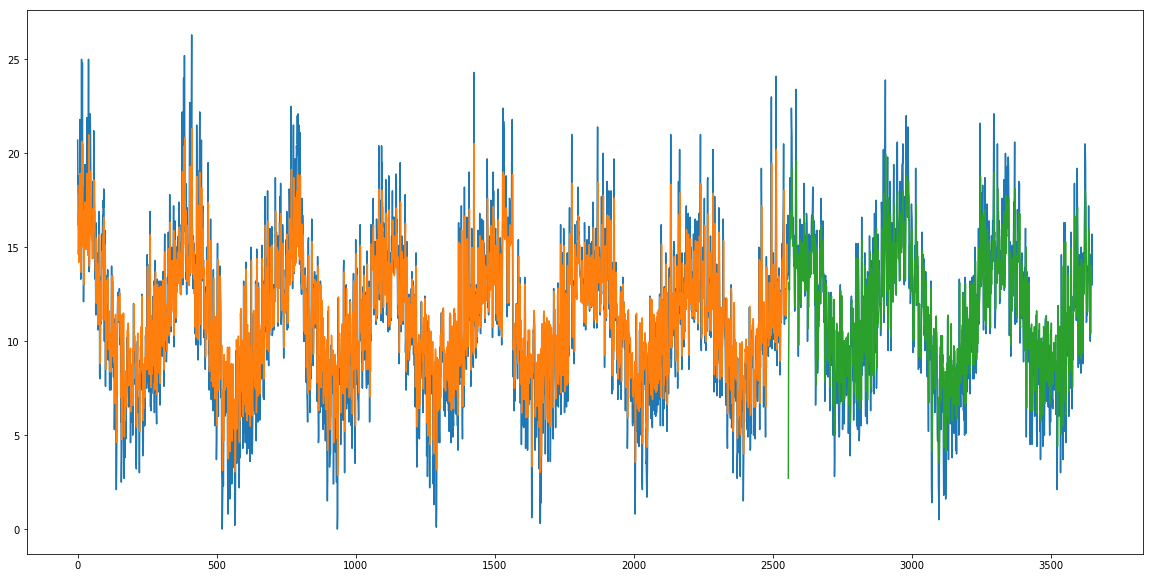

In [0]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()